In [53]:
import numpy as np
import pandas as pd
import re
import pickle
import lightgbm as lgb
from sklearn.model_selection import cross_validate, KFold
import matplotlib.pyplot as plt
from collections import Counter
import MeCab

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'IPAGothic'

In [59]:
mecab_param = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

In [158]:
train = pd.read_csv("../data/train_Youto_sentence_and_heading.csv")

with open("../dump/noun_list.pickle", 'br') as f:
    noun_list = pickle.load(f)

with open("../dump/clue_words.pickle", 'br') as f:
    clue_word_by_BS = pickle.load(f)
    
clue_word_entropy = pd.read_csv("../data/clue_word_of_Sahen-setsuzoku_with_beta=0.1.csv", names=['clue_word']).clue_word.values

In [159]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train = train.loc[train.sentence.str.contains("|".join(clue_word_by_BS))].reset_index(drop=True)
print("train length (filtering) :", len(train))
print("label 1 :", len(train.loc[train.label == 1]), "\tlabel 0 :", len(train.loc[train.label == 0]))

train length : 6671
label 1 : 1514 	label 0 : 5157
train length (filtering) : 3341
label 1 : 1045 	label 0 : 2296


In [183]:
# 文中に各手がかり語が含まれているどうかの特徴量を作成

feature_word_dict = {}

for word in np.append(clue_word_entropy, ['用途', '効果', '目的', '用い', '使わ']):
    feature_word_dict[word] = train.sentence.str.contains(fr'{word}').tolist()

In [184]:
# サブタイトル名をもとにカテゴリ変数を作成する

train = train.assign(heading_cat = np.nan)

cat1 = r'NO_SUBTITLE'
train.loc[train.heading.str.contains(cat1), 'heading_cat'] = 0

cat2 = r'|'.join(np.append(clue_word_entropy, ['用途', '効果', '目的']))
train.loc[train.heading.str.contains(cat2), 'heading_cat'] = 1

train.loc[train.heading_cat.isna(), 'heading_cat'] = 2

train.heading_cat = train.heading_cat.astype('category') 

In [163]:
# 文中にカテゴリ名が含まれているどうか

category_list = '|'.join(pd.read_csv("../data/category_in_noun_list.csv").category.values)
is_contain_cat = train.sentence.str.contains(category_list).tolist()

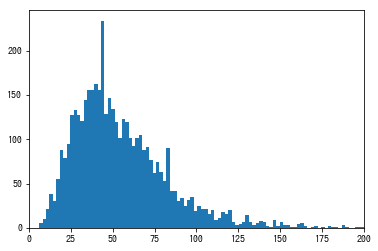

In [152]:
# 文字列長を特徴量にする

plt.xlim((0, 200))
plt.hist(train.sentence.str.len(), bins=500)
plt.show()

In [164]:
train = train.assign(length_cat = np.nan)

train.loc[train.sentence.str.len() < 25, 'length_cat'] = 0
train.loc[(train.sentence.str.len() >= 25) & (train.sentence.str.len() < 50), 'length_cat'] = 1
train.loc[(train.sentence.str.len() >= 50) & (train.sentence.str.len() < 75), 'length_cat'] = 2
train.loc[(train.sentence.str.len() >= 75) & (train.sentence.str.len() < 100), 'length_cat'] = 3
train.loc[train.sentence.str.len() >= 100, 'length_cat'] = 4

train.length_cat = train.length_cat.astype('category') 

### 最後にマッチングした手がかり語より前5単語の品詞をカテゴリ変数として特徴量を作成

In [145]:
def remove_clue_word_from_sentence(s, clue_word_list):
    return s[:list(re.finditer(r'|'.join(clue_word_list), s))[-1].start()]

def get_hinshi_list(s, prev=5):
    if len(s) is 0:
        return [np.nan] * prev
    
    node = mecab_param.parseToNode(s)
    hinshi = []
    while node:
        if len(node.surface) is 0:
            node = node.next
            continue

        hinshi.append(node.feature.split(',')[0])
        node = node.next
    
    return hinshi[::-1][:prev]

In [166]:
hinshi_df = \
pd.concat(
    [train
    , pd.DataFrame(
        train.sentence.apply(remove_clue_word_from_sentence, args=(clue_word_by_BS,)).apply(get_hinshi_list).tolist()
        , columns=[
            'prev1_hinshi_cat'
            , 'prev2_hinshi_cat'
            , 'prev3_hinshi_cat'
            , 'prev4_hinshi_cat'
            , 'prev5_hinshi_cat']
        , dtype='category'
    )]
    , axis=1
)

In [195]:
train_X = \
pd.DataFrame(feature_word_dict).assign(
    heading_cat = train.heading_cat
    , is_contain_cat = is_contain_cat
    #, length_cat = train.length_cat
    , prev1_hinshi_cat = hinshi_df.prev1_hinshi_cat
    , prev2_hinshi_cat = hinshi_df.prev2_hinshi_cat
    , prev3_hinshi_cat = hinshi_df.prev3_hinshi_cat
    , prev4_hinshi_cat = hinshi_df.prev4_hinshi_cat
    , prev5_hinshi_cat = hinshi_df.prev5_hinshi_cat
)
train_y = train.label.tolist()

In [196]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.6624936866742639
precision:  0.7149096215394148
recall:  0.6200956937799043


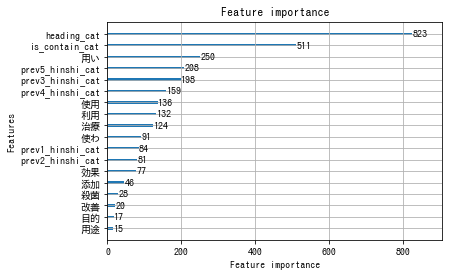

In [197]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [189]:
predict = model.predict(train_X)

In [190]:
TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

In [191]:
print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  736
TN:  2138
FP:  158
FN:  309


In [192]:
print(train.loc[FN_index, 'sentence'].values)

['日本では配合用の原末が医療用に販売されているほか、第2類医薬品として市販の風邪薬に配合されている。'
 'ケトチフェン（Ketotifen）は第二世代の非競合的H1ヒスタミン受容体遮断薬で肥満細胞安定化薬（英語版）である。'
 'オシメルチニブ（Osimertinib、旧名：メレレチニブ、mereletinib）は、第三世代の上皮成長因子受容体（EGFR）チロシンキナーゼ阻害薬（英語版）（TKI）である。'
 'したがって、これらから作られた飲食物、例えば、各種コーヒー飲料、緑茶、ウーロン茶、紅茶、ココアなどの飲料や、チョコレートなどの加工食品にもカフェインは含まれる。'
 '飲食品では主に、コーヒー飲料、緑茶、ウーロン茶、紅茶、ココア、コーラや栄養ドリンクなどの飲料、チョコレートなどにカフェインが含まれる。'
 '市販の鎮痛薬に含まれるカフェインや他の成分の依存や離脱症状が薬物乱用頭痛の発症に寄与する。'
 '医療分野において医薬品医療機器等法では1回（1錠・1包等）あたりに500mg以上のカフェインを含むものを劇薬に指定している。'
 'イブルチニブは慢性リンパ性白血病（CLL）細胞のケモカイン（CXCL12およびCXCL13）に対する走化性を減少させ、B細胞受容体（BCR）への刺激に基づく細胞接着を阻害する。'
 "経口投与可能な選択的不可逆的酵素阻害薬であり、ブルトン型チロシンキナーゼ(Bruton's tyrosine kinase; BTK）を阻害する。"
 '日本では2016年3月に「再発または難治性の慢性リンパ性白血病（小リンパ球性リンパ腫を含む）」について承認された。'
 'ネビラピンは非ヌクレオシド系逆転写酵素阻害薬（NNRTI）に分類される抗レトロウイルス薬である。'
 '酵素の活性中心に結合するヌクレオシド系薬剤とは異なり、NNRTIは活性部位から離れたNNRTIポケットと呼ばれる部位に結合し、酵素の立体構造を変化させ失活させる。'
 'NNRTIの殆どは酵素の同じ部位に結合するので、ネビラピン耐性となったウイルス株は他のNNRTI（エファビレンツ（英語版）やデラビリジン（英語版）等）にも耐性を持っている。'
 'しかしリルピビリン（英語版）やエトラビリン（英語版）等の第2世代のNNRTIは、ネビラピン等の第1世代NNRTIに耐性のウイル